In [7]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

2022-09-01 14:01:44.657935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 14:01:44.657964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
#loading data
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

mnist data consists of 70000 images, each of 28x28 pixels

X_train -> 60000 x 28 x 28

Y_train -> 60000 x 1

X_test -> 10000 x 28 x 28

Y_test -> 10000 x 1

example : 34232 ------> label : 7


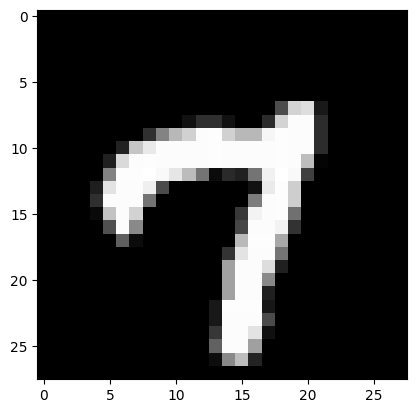

In [9]:
#X_train -> 60000 x 28 x 28

#visualizing the data
index = 34232
plt.imshow(X_train[index],cmap = 'gray')
print(f"example : {index} ------> label : {Y_train[index]}")

In [10]:
# reshaping and standardizing the data
X = (X_train.reshape(X_train.shape[0],-1).T)/255
Ytemp = Y_train.reshape(Y_train.shape[0],-1).T

'''
X = 784 x 60000
Y = 1 x 60000 
'''
X_dev = (X_test.reshape(X_test.shape[0],-1).T)/255
Y_devtemp = Y_test.reshape(Y_test.shape[0],-1).T
'''
X_dev = 784 x 10000
Y_dev = 1 x 10000
'''

'''
'''

Y=np.zeros((10,Ytemp.shape[1]))
for i in range(Ytemp.shape[1]):
    Y[Ytemp[0,i],i]=1

Y_dev=np.zeros((10,Y_devtemp.shape[1]))
for i in range(Y_devtemp.shape[1]):
    Y_dev[Y_devtemp[0,i],i]=1


In [11]:
def initialize_params(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layer_dims[l],1))
    return parameters
    

In [12]:
def get_activation(A,W,b,func):
    Z = np.dot(W,A) + b
    linear_cache = (A,W,b)
    activation_cache = (Z)
    
    cache = (linear_cache,activation_cache)
    
    if func=="Lrelu" :
        A = np.where(Z>0,Z,0.01*Z)
        
        
    elif func=="sigmoid" :
        A = 1/(1+np.exp(-Z))
    
    elif func=="softmax" :
        A = np.exp(Z)/np.sum(np.exp(Z),axis=0)
    
    return A,cache



def forward_propagation(X,parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L) :
        A,cache = get_activation(A,parameters["W"+str(l)],parameters["b"+str(l)],"Lrelu")
        caches.append(cache)
    
    #print(A)
    Y_hat,cache = get_activation(A,parameters["W"+str(L)],parameters["b"+str(L)],"softmax")
    caches.append(cache)
    #print(Y_hat)
    return Y_hat,caches
        

In [21]:
def compute_cost(Y_hat,Y,m) : 
    cost = (-1/m)*np.sum((Y*np.log(Y_hat)) + ((1-Y)*np.log((1-Y_hat))))
                   
    #cost = -(1/m)*np.sum((Y*np.log(AL)))
    cost = np.squeeze(cost)
    return cost

dA of layer L -> gives us dW, db of Lth layer and dA of L-1 layer

the we use dA of layer L-1 to get dW, db of layer L-1 and dA of layer L-2

and so on

In [14]:
def get_activation_backward(Y_hat,dA,cache,func) :
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache
    Z = activation_cache
    
    m = A_prev.shape[1]
    
    if func == "Lrelu" :
        #derivative of activation wrt to Z
        temp = np.where(Z>0,1,0.01)
        dZ = dA*temp
    elif func == "sigmoid" :
        sig = 1/(1+np.exp(-Z))
        dZ = Y_hat - Y
        
    elif func == "softmax" :
        soft = np.exp(Z)/np.sum(np.exp(Z))
        dZ = Y_hat - Y
    
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    
    return dA_prev, dW, db



def backward_propagation(Y_hat,Y,caches) :
    
    grads = {}
    L = len(caches) # the number of layers
    Y = Y.reshape(Y_hat.shape)
    
    
    #compute derivative of predicted output wrt cost (dJ/dY_hat)
    #dY_hat = dA of layer L
    #dY_hat = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    
    #computing dW,db, of layer L and dA of layer L-1
    
#     dA_prev,dW,db = get_activation_backward(Y_hat,dY_hat,caches[L-1],"softmax")
    
#     grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = dA_prev,dW,db

    last_layer_cache = caches[L-1]
    linear_cache, activation_cache = last_layer_cache
    A_prev, W, b = linear_cache
    Z = activation_cache
    m = A_prev.shape[1]
    
    dZ = Y_hat - Y
    grads["dA"+str(L-1)] = np.dot(W.T,dZ)
    grads["dW"+str(L)]   = (1/m)*np.dot(dZ,A_prev.T)
    grads["db"+str(L)]   = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    
    dA_prev = grads["dA"+str(L-1)]
    
    #loop from L-2 to 0
    for l in reversed(range(L-1)) :
        
        current_layer_cache = caches[l]
        dA_prev,dw,db = get_activation_backward(Y_hat,dA_prev,current_layer_cache,"Lrelu")
        
        grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)] = dA_prev,dw,db
        
        
    return grads

In [15]:
def update_params(params,grads,learning_rate):
    L = len(params)//2
    parameters = params.copy()
    for l in range(L) :
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - (learning_rate * grads["dW"+str(l+1)])
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - (learning_rate * grads["db"+str(l+1)])
        
    return parameters

In [52]:
def get_predictions(Y_hat):
    return np.argmax(Y_hat,0)

def get_accuracy(predictions,Y):
    predictions = predictions.reshape(1,predictions.shape[0])
    #print(predictions.shape)
    ans = 0
    for i in range(Y.shape[1]) :
        predict = predictions[0,i]
        if Y[predict,i]==1 :
            ans+=1
    print(ans)
    return str((ans/Y.shape[1])*100) + '%'

def predict_L_layer(X,parameters):
    AL,caches=forward_propagation(X,parameters)
    prediction=np.argmax(AL,axis=0)
    prediction.reshape(1,prediction.shape[0])
    ans = 0
    for i in range(10000) :
        if prediction[0,i]==Y_dev[0,i] : 
            ans+=1
    print(ans)
    #return prediction.reshape(1,prediction.shape[0])

In [47]:
def model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):
    costs = []
    parameters = initialize_params(layers_dims)
    
    #print(parameters)
    for i in range(0, num_iterations):
        Y_hat, caches = forward_propagation(X,parameters)
        
        
        cost = compute_cost(Y_hat,Y,Y.shape[1])
        
        grads = backward_propagation(Y_hat,Y,caches)
        
        parameters = update_params(parameters,grads,learning_rate)
        
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            #print(get_predictions(Y_hat).shape)
            #print(Y.shape)
            print("accuracy : ",get_accuracy(get_predictions(Y_hat),Y))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
            
    return parameters,costs

In [48]:
parameters, costs = model(X,Y,[784,56,10],0.1,3000,True)

#predictions_test_L=predict_L_layer(X_dev,parameters)



Cost after iteration 0: 3.251201142421806
5296
accuracy :  8.826666666666666%
Cost after iteration 100: 1.8066448148433034
44307
accuracy :  73.845%
Cost after iteration 200: 0.9212949503149214
51371
accuracy :  85.61833333333333%
Cost after iteration 300: 0.7159495582372121
53128
accuracy :  88.54666666666667%
Cost after iteration 400: 0.6280953950200298
53811
accuracy :  89.685%
Cost after iteration 500: 0.5792253823918825
54198
accuracy :  90.33%
Cost after iteration 600: 0.5464372225120203
54466
accuracy :  90.77666666666667%
Cost after iteration 700: 0.5216901900874703
54705
accuracy :  91.175%
Cost after iteration 800: 0.5015999077150896
54917
accuracy :  91.52833333333334%
Cost after iteration 900: 0.48442551123313815
55094
accuracy :  91.82333333333334%
Cost after iteration 1000: 0.4690068545840386
55247
accuracy :  92.07833333333333%
Cost after iteration 1100: 0.4548337269521723
55408
accuracy :  92.34666666666666%
Cost after iteration 1200: 0.4418713283188889
55544
accuracy :

In [53]:
#testing
predictions,cache = forward_propagation(X_dev,parameters)
print(predictions.shape)

print("accuracy : ",get_accuracy(get_predictions(predictions),Y_dev))

(10, 10000)
9508
accuracy :  95.08%
